In [1]:
import geopandas as gpd 
import shutil
import glob 

In [2]:
import pandas as pd

SPECIES_NAME = 'Ursus_arctos_Linnaeus'
# SPECIES_NAME = 'Theropithecus_gelada'
# SPECIES_NAME = 'Camelus_dromedarius_Linnaeus'
train_vec = pd.read_csv(f"../../data/csv/{SPECIES_NAME}.csv")
train_vec.head()

,CLASS,bclim1,bclim10,bclim11,bclim12,bclim13,bclim14,bclim15,bclim16,bclim17,bclim18,bclim19,bclim2,bclim3,bclim4,bclim5,bclim6,bclim7,bclim8,bclim9
0,1.0,27.0,119.0,-59.0,951.0,104.0,49.0,22.0,289.0,168.0,245.0,249.0,69.0,25.0,6905.0,168.0,-99.0,267.0,80.0,14.0
1,0.0,186.0,256.0,120.0,809.0,201.0,1.0,100.0,499.0,4.0,14.0,383.0,67.0,31.0,5424.0,298.0,86.0,212.0,137.0,255.0
2,1.0,30.0,113.0,-58.0,1225.0,176.0,65.0,35.0,467.0,203.0,467.0,216.0,80.0,29.0,6721.0,167.0,-102.0,269.0,113.0,-51.0
3,1.0,40.0,119.0,-34.0,1256.0,143.0,63.0,23.0,393.0,227.0,290.0,336.0,66.0,28.0,5981.0,165.0,-69.0,234.0,47.0,65.0
4,1.0,-1.0,103.0,-104.0,628.0,95.0,24.0,44.0,259.0,83.0,259.0,96.0,76.0,24.0,8021.0,162.0,-144.0,306.0,103.0,-95.0


In [3]:
print("number of NA's: ", train_vec.isna().sum())
train_vec=train_vec.dropna()
print("number of NA's: ", train_vec.isna().sum())

number of NA's:  CLASS       0
bclim1     10
bclim10    10
bclim11    10
bclim12    10
bclim13    10
bclim14    10
bclim15    10
bclim16    10
bclim17    10
bclim18    10
bclim19    10
bclim2     10
bclim3     10
bclim4     10
bclim5     10
bclim6     10
bclim7     10
bclim8     10
bclim9     10
dtype: int64
number of NA's:  CLASS      0
bclim1     0
bclim10    0
bclim11    0
bclim12    0
bclim13    0
bclim14    0
bclim15    0
bclim16    0
bclim17    0
bclim18    0
bclim19    0
bclim2     0
bclim3     0
bclim4     0
bclim5     0
bclim6     0
bclim7     0
bclim8     0
bclim9     0
dtype: int64


## 섹션 2 | 종 적합성(Species suitability) 매핑

In [5]:
# 래스터 특징
raster_features = sorted(glob.glob(
    f'../../data/worldclim/{SPECIES_NAME}/bclim*.asc'))
print(raster_features)

['../../data/worldclim/Ursus_arctos_Linnaeus\\bclim1.asc', '../../data/worldclim/Ursus_arctos_Linnaeus\\bclim10.asc', '../../data/worldclim/Ursus_arctos_Linnaeus\\bclim11.asc', '../../data/worldclim/Ursus_arctos_Linnaeus\\bclim12.asc', '../../data/worldclim/Ursus_arctos_Linnaeus\\bclim13.asc', '../../data/worldclim/Ursus_arctos_Linnaeus\\bclim14.asc', '../../data/worldclim/Ursus_arctos_Linnaeus\\bclim15.asc', '../../data/worldclim/Ursus_arctos_Linnaeus\\bclim16.asc', '../../data/worldclim/Ursus_arctos_Linnaeus\\bclim17.asc', '../../data/worldclim/Ursus_arctos_Linnaeus\\bclim18.asc', '../../data/worldclim/Ursus_arctos_Linnaeus\\bclim19.asc', '../../data/worldclim/Ursus_arctos_Linnaeus\\bclim2.asc', '../../data/worldclim/Ursus_arctos_Linnaeus\\bclim3.asc', '../../data/worldclim/Ursus_arctos_Linnaeus\\bclim4.asc', '../../data/worldclim/Ursus_arctos_Linnaeus\\bclim5.asc', '../../data/worldclim/Ursus_arctos_Linnaeus\\bclim6.asc', '../../data/worldclim/Ursus_arctos_Linnaeus\\bclim7.asc', '..

In [6]:
# 래스터 특징 수 확인
print(len(raster_features), '개 래스터 특징')

19 개 래스터 특징


In [7]:
# pyimpute 모듈
from pyimpute import load_targets

In [8]:
train_xs, train_y = train_vec.iloc[:,1:20].values, train_vec.iloc[:,0].values # 훈련 데이터 로드
target_xs, raster_info = load_targets(raster_features) # scikit-learn용 데이터 구조로 래스터 특징 로드
train_xs.shape, train_y.shape # 관측치 크기와 일치하는지 shape 확인

((39614, 19), (39614,))

In [9]:
# ML 분류기 로드
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import svm, metrics


In [10]:
# ML 분류기 딕셔너리: 이름, (모델)
CLASS_MAP = {
    'RF': (RandomForestClassifier()),
    'ET': (ExtraTreesClassifier()),
    'XGB': (XGBClassifier()),
    'LGBM': (LGBMClassifier()),
    }

In [11]:
# pyimpute, sklearn 로드
from pyimpute import impute
from sklearn import model_selection

In [12]:
# 모델 피팅 및 공간 예측(model fitting and spatial range prediction)
SAVE_PATH = f'../../data/sdm/{SPECIES_NAME}_prediction/'

import os
if not os.path.exists(SAVE_PATH):
      os.mkdir(SAVE_PATH)

for name, (model) in CLASS_MAP.items():
    # 교차 검증(cross validation)
    k = 5 # k-fold
    kf = model_selection.KFold(n_splits=k)
    accuracy_scores = model_selection.cross_val_score(model, train_xs, train_y, cv=kf, scoring='accuracy')
    print(name + " %d-fold 교차 검증 정확도: %0.2f (+/- %0.2f)"
          % (k, accuracy_scores.mean() * 100, accuracy_scores.std() * 200))
    
    # 공간 예측(spatial prediction)
    model.fit(train_xs, train_y)
    if not os.path.exists(SAVE_PATH + name + '-IMAGES'):
      os.mkdir(SAVE_PATH + name + '-IMAGES')
    impute(target_xs, model, raster_info, outdir= SAVE_PATH + name + '-IMAGES',
           class_prob=True, certainty=True)
from sklearn import svm, metrics

svm = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.5)


RF 5-fold 교차 검증 정확도: 95.74 (+/- 0.40)
ET 5-fold 교차 검증 정확도: 95.64 (+/- 0.43)
XGB 5-fold 교차 검증 정확도: 95.43 (+/- 0.23)
LGBM 5-fold 교차 검증 정확도: 95.19 (+/- 0.24)


In [13]:
import rasterio
distr_rf = rasterio.open( SAVE_PATH+ "RF-IMAGES/probability_1.0.tif").read(1)
distr_et = rasterio.open( SAVE_PATH+"ET-IMAGES/probability_1.0.tif").read(1)
distr_xgb =  rasterio.open(SAVE_PATH+"XGB-IMAGES/probability_1.0.tif").read(1)
distr_lgbm =  rasterio.open(SAVE_PATH+"LGBM-IMAGES/probability_1.0.tif").read(1)
distr_averaged = (distr_rf + distr_et + distr_xgb + distr_lgbm)/4

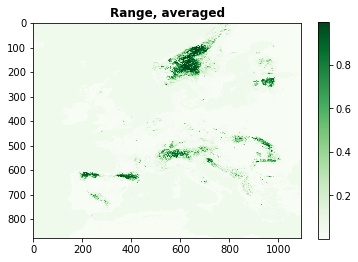

In [14]:
# 종 적합성 매핑의 평균값 가시화
from pylab import plt

def plotit(x, title, cmap="Blues"):
    plt.imshow(x, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.title(title, fontweight = 'bold')

plotit(distr_averaged, "Range, averaged", cmap="Greens")

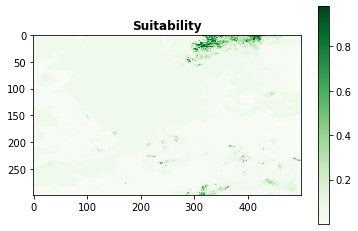

In [15]:
plotit(distr_averaged[200:500, 250:750], "Suitability", cmap="Greens")